In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input,Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import os
import zipfile


def extract_file(file_path, extract_to):
    if not os.path.exists(file_path):
        print(f'The file {file_path} does not exist.')
        return

    if file_path.endswith('.zip'):
        try:
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f'Successfully unzipped {file_path} to {extract_to}')
        except zipfile.BadZipFile as e:
            print(f'Failed to unzip {file_path}: {e}')
    elif file_path.endswith('.rar'):
        try:
            with rarfile.RarFile(file_path, 'r') as rar_ref:
                rar_ref.extractall(extract_to)
            print(f'Successfully extracted {file_path} to {extract_to}')
        except rarfile.Error as e:
            print(f'Failed to extract {file_path}: {e}')
    else:
        print(f'Unsupported file type: {file_path}')

zip_file_path = '/content/drive/MyDrive/other.zip'
extract_path = '/content/'

extract_file(zip_file_path, extract_path)


Successfully unzipped /content/drive/MyDrive/other.zip to /content/


In [ ]:
import shutil
import os

def copy_folder(src, dest):
    # Check if source folder exists
    if not os.path.exists(src):
        print(f"Source folder '{src}' does not exist.")
        return

    # Check if destination folder exists, create if it does not
    if not os.path.exists(dest):
        os.makedirs(dest)

    try:
        # Copy the folder and its contents
        shutil.copytree(src, dest, dirs_exist_ok=True)
        print(f"Folder '{src}' successfully copied to '{dest}'")
    except Exception as e:
        print(f"Error copying folder: {e}")

# Test Folder
# src_folder = '/content/other/test'
# dest_folder = '/content/bone_marrow_dataset_splitted/test'
# copy_folder(src_folder, dest_folder)

#Train Folder
# src_folder = '/content/other/train'
# dest_folder = '/content/bone_marrow_dataset_splitted/train'
# copy_folder(src_folder, dest_folder)

#Val Folder
# src_folder = '/content/other/val'
# dest_folder = '/content/bone_marrow_dataset_splitted/val'
# copy_folder(src_folder, dest_folder)

Folder '/content/other/val' successfully copied to '/content/bone_marrow_dataset_splitted/val'


In [ ]:
img_shape = (250, 250, 3)
num_classes = 10
batch_size = 128
train_path = '/content/bone_marrow_dataset_splitted/train'
val_path = '/content/bone_marrow_dataset_splitted/val'
test_path = '/content/bone_marrow_dataset_splitted/test'
classes = ['MYB', 'PMO', 'LYT', 'other', 'EBO', 'NGB', 'PLM', 'BLA', 'ART', 'NGS']

In [ ]:
def load_and_preprocess_image(img_path, target_size=img_shape):
    try:
        img = load_img(img_path, color_mode='rgb', target_size=(target_size[0], target_size[1]))
        img_array = img_to_array(img)
        img_array /= 255.0
        return img_array
    except Exception as e:
        print(f"Error loading image {img_path}: {str(e)}")
        return None

In [ ]:
def generator_fn(image_paths, labels, batch_size=128):
    num_samples = len(image_paths)
    while True:
        indices = np.random.choice(num_samples, batch_size, replace=False)
        batch_image_paths = [image_paths[i] for i in indices]
        batch_labels = [labels[i] for i in indices]

        # Load and preprocess the batch of images
        batch_images = [load_and_preprocess_image(img_path) for img_path in batch_image_paths]
        batch_images = [img for img in batch_images if img is not None]

        # If all images failed to load, skip the batch
        if not batch_images:
            continue

        # One-hot encode the labels
        batch_labels_one_hot = to_categorical(batch_labels, num_classes)

        # Ensure the batch size matches the specified batch_size
        if len(batch_images) < batch_size:
            extra_samples = batch_size - len(batch_images)
            extra_indices = np.random.choice(num_samples, extra_samples, replace=False)
            extra_batch_image_paths = [image_paths[i] for i in extra_indices]
            extra_batch_labels = [labels[i] for i in extra_indices]
            extra_batch_images = [load_and_preprocess_image(img_path) for img_path in extra_batch_image_paths]
            extra_batch_images = [img for img in extra_batch_images if img is not None]
            batch_images.extend(extra_batch_images)
            batch_labels.extend(extra_batch_labels)

        yield np.array(batch_images), np.array(batch_labels_one_hot)


In [ ]:
def get_image_paths_and_labels(dataset_path, classes):
    image_paths = []
    labels = []
    for label, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(label)
    return image_paths, labels

In [ ]:
train_image_paths, train_labels = get_image_paths_and_labels(train_path, classes)
val_image_paths, val_labels = get_image_paths_and_labels(val_path, classes)
test_image_paths, test_labels = get_image_paths_and_labels(test_path, classes)

In [ ]:
train_generator = generator_fn(train_image_paths, train_labels, batch_size=batch_size)
val_generator = generator_fn(val_image_paths, val_labels, batch_size=batch_size)
test_generator = generator_fn(test_image_paths, test_labels, batch_size=batch_size)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Flatten,Input, UpSampling2D
from tensorflow.keras import models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

def classification_model(image_shape, num_classes, trainable_layers=None):
    base_mobilenet = MobileNet(include_top=False, weights='imagenet', input_shape=image_shape)

    # Freeze or unfreeze layers based on the specified list
    if trainable_layers is not None:
        for layer in base_mobilenet.layers:
            if layer.name in trainable_layers:
                layer.trainable = True
            else:
                layer.trainable = False

    # Define your custom model architecture
    custom_model = models.Sequential()

    # Add the MobileNet base model
    custom_model.add(base_mobilenet)

    # Add your custom convolutional layers
    custom_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.1))

    custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    custom_model.add(Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())

    custom_model.add(Conv2D(128, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    custom_model.add(Conv2D(64, (3, 3), padding='same', dilation_rate=(2, 2), kernel_regularizer=l2(0.001)))
    custom_model.add(BatchNormalization())
    custom_model.add(Dropout(0.1))

    custom_model.add(Flatten())
    custom_model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
    custom_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    custom_model.add(Dropout(0.2))
    custom_model.add(Dense(num_classes, activation='softmax'))

    return custom_model


reduced_output_shape = (250, 250, 3)
num_classes = 10
mobilenet_model = classification_model(reduced_output_shape, num_classes)

mobilenet_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          294944    
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization (Batch  (None, 7, 7, 64)          256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                         

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import shutil

lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.9)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/model/best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
callbacks_list = [checkpoint, lr_reduction, early_stopping]

steps_per_epoch_train = len(train_image_paths) // batch_size
steps_per_epoch_val = len(val_image_paths) // batch_size

# Calculate the number of steps for validation
validation_steps = len(val_image_paths) // batch_size

mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



history = mobilenet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

colab_model_path = '/model/best_model.h5'

# Define the path for the best model in Google Drive
drive_model_path = '/content/drive/MyDrive/bonemarrow10classes'

# Save the trained model
mobilenet_model.save(colab_model_path)
shutil.copy(colab_model_path, drive_model_path)


Epoch 1/20
993/993 [==============================] - ETA: 0s - loss: 0.9815 - accuracy: 0.8344
Epoch 1: val_accuracy improved from -inf to 0.81619, saving model to /model/best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


993/993 [==============================] - 855s 837ms/step - loss: 0.9815 - accuracy: 0.8344 - val_loss: 0.6755 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 2/20
993/993 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8795
Epoch 2: val_accuracy improved from 0.81619 to 0.84109, saving model to /model/best_model.h5
993/993 [==============================] - 856s 862ms/step - loss: 0.4741 - accuracy: 0.8795 - val_loss: 0.5952 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 3/20
993/993 [==============================] - ETA: 0s - loss: 0.4106 - accuracy: 0.8924
Epoch 3: val_accuracy improved from 0.84109 to 0.86906, saving model to /model/best_model.h5
993/993 [==============================] - 857s 863ms/step - loss: 0.4106 - accuracy: 0.8924 - val_loss: 0.4553 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 4/20
993/993 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.9032
Epoch 4: val_accuracy did not improve from 0.86906

Epoch 4: ReduceLROnPlateau red

'/content/drive/MyDrive/bonemarrow10classes'

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/bonemarrow10classesgraphs/training_validation_plots.png'

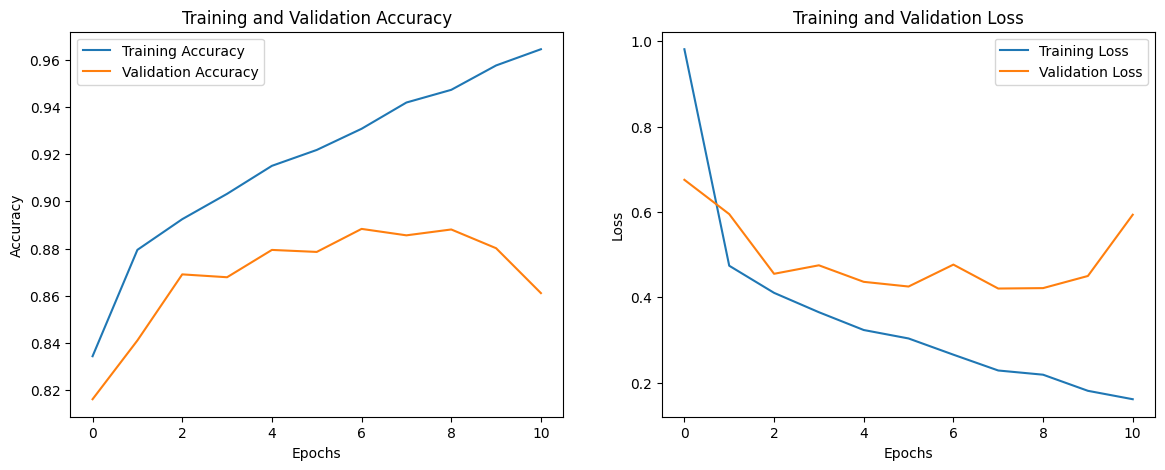

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy and loss

# Retrieve a list of accuracy results on training and validation data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of loss results on training and validation data
loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve the number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the plot to the specified path
save_path = '/content/drive/MyDrive/bonemarrow10classesgraphs/training_validation_plots.png'
plt.savefig(save_path)

# Show the plot
plt.show()


In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.7 MB/s eta 0:00:00


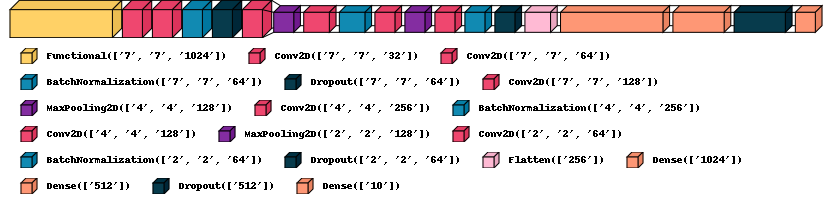

In [ ]:
import visualkeras



visualkeras.layered_view(mobilenet_model).show() # display using your system viewer
visualkeras.layered_view(mobilenet_model, to_file='output.png') # write to disk
visualkeras.layered_view(mobilenet_model, to_file='output.png').show() # write and show
visualkeras.layered_view(mobilenet_model, legend=True, show_dimension=True)